In [10]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import math
import imutils
from functools import cmp_to_key
from multiprocessing import Process, Manager, Pool, Queue

In [13]:
# Read directory function
array_of_img = []
def read_directory(directory_name):
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
def linearBlendingWithConstantWidth(imgs):
        '''
        linear Blending with Constat Width, avoiding ghost region
        # you need to determine the size of constant with
        '''
        img_left, img_right = imgs
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        constant_width = 3 # constant width
        
        # find the left image and right image mask region(Those not zero pixels)
        for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1
                    
        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1
        
        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr):
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j
            
            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            
            # Find the middle line of overlapping regions, and only do linear blending to those regions very close to the middle line.
            middleIdx = int((maxIdx + minIdx) / 2)
            
            # left 
            for j in range(minIdx, middleIdx + 1):
                if (j >= middleIdx - constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 1
            # right
            for j in range(middleIdx + 1, maxIdx + 1):
                if (j <= middleIdx + constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 0

        
        linearBlendingWithConstantWidth_img = np.copy(img_right)
        linearBlendingWithConstantWidth_img[:hl, :wl] = np.copy(img_left)
        # linear blending with constant width
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlendingWithConstantWidth_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]
        
        return linearBlendingWithConstantWidth_img        

def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
    translation_dist = [-x_min, -y_min]
  
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img = linearBlendingWithConstantWidth([img1, output_img])
#     output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
    return output_img, output_img.shape[1], output_img.shape[0], H_translation
   
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    
def trim(frame):
    
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
#     for i in range(frame.shape[1]):
# #         ran = np.random.randint(frame.shape[0], size=10)
#         black = True
#         for j in range(5):
#             if (frame[j][i] != np.array([0,0,0])).all():
#                 black = False
#             if (frame[frame.shape[0] - j - 1][i] != np.array([0,0,0])).all():
#                 black = False
#         if black == True:
#             if (frame[0][i] == np.array([0,0,0])).all():
#                 if i == 0:
#                     return trim(frame[:, 1:])
#                 if i == frame.shape[1] - 1:
#                     return trim(frame[:, :-2])
#                 else:
#                     return trim(np.concatenate((frame[:, :i-1], frame[:, i+1:]), axis=1))
#             if (frame[-1][i] == np.array([0,0,0])).all():
#                 if i == 0:
#                     return trim(frame[:, 1:])
#                 if i == frame.shape[1] - 1:
#                     return trim(frame[:, :-2])
#                 else:
#                     return trim(np.concatenate((frame[:, :i-1], frame[:, i+1:]), axis=1))
    return frame

def SIFT(inputname):
    read_directory(inputname)
    h, w = array_of_img[0].shape[:2]
    K = np.array([[800,0,w/2],[0,800,h/2],[0,0,1]]) # mock intrinsics
    for i in range(len(array_of_img)):
        array_of_img[i] = trim(cylindricalWarp(array_of_img[i], K))
        array_of_img[i] = trim(array_of_img[i])

    keypoints = []
    descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()
    for i in range(len(array_of_img)):
        tmp_keypoint, tmp_descriptor = sift.detectAndCompute(array_of_img[i], None)
        keypoints.append(tmp_keypoint)
        descriptors.append(tmp_descriptor)
    homography= []
    for i in range(len(keypoints)-1):
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
        matches = bf.match(descriptors[i], descriptors[i+1])
        matches = sorted(matches, key=lambda x:x.distance)

        src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in matches[:50]]).reshape(-1,1,2)
        dst_pts = np.float32([keypoints[i+1][m.trainIdx].pt for m in matches[:50]]).reshape(-1,1,2)
        M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)        
        homography.append(M)

    all_var_width = []
    all_var_height = []
    for i in range(len(homography)):
        top = np.array([[array_of_img[i].shape[1], 0], [0, 0]], dtype=np.float)
        new_top = cv2.perspectiveTransform(top[None, :, :], homography[i])
        var_width = new_top[0][0][0] - new_top[0][1][0]
        all_var_width.append(var_width)
        translation_dist = [var_width, 0]
        W_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        top = np.array([[0, array_of_img[i].shape[0]], [0, 0]], dtype=np.float)
        new_top = cv2.perspectiveTransform(top[None, :, :], homography[i])
        var_height = new_top[0][0][1] - new_top[0][1][1]
        all_var_height.append(var_height)
        translation_dist = [0, var_height]
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        for j in range(i+1, len(homography)):
            homography[j] = W_translation.dot(homography[j])
            homography[j] = H_translation.dot(homography[j])
            
    for i in range(1, len(array_of_img)):
        original_width = array_of_img[0].shape[1]
        original_height = array_of_img[0].shape[0]
        tmp, width_of_tmp, height_of_tmp, translation = warpImages(array_of_img[0], array_of_img[i], homography[i-1])
        array_of_img[0] = trim(tmp)
        var = original_width +  all_var_width[i-1] - width_of_tmp
        translation_dist = [-var, 0]
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        var = original_height + all_var_height[i-1] - height_of_tmp
        translation_dist = [0, -var]
        W_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        
        for j in range(i, len(homography)):
            homography[j] = H_translation.dot(homography[j])
            homography[j] = W_translation.dot(homography[j])
            homography[j] = translation.dot(homography[j])
    imageoutput = array_of_img[0]
    array_of_img.clear()
    return imageoutput

156.0735514163971


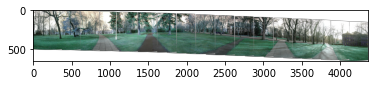

In [14]:
f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname):
    start = time.time()
    imageout=SIFT(dirname)
    print(time.time()-start)
    plt.figure()
    plt.imshow(imageout)
    cv2.imwrite(dirname+'.jpg', imageout)
    dirname = str(f.readline()).strip()